# Classification Problem


In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2 as cv
import PIL


In [138]:
# Load Dataset
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [139]:
# Create Input Dataset

# Define Class Name and number of Class
CLASS_NUM = 8
CLASS_LIST = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
FEATURE_SIZE = 28 * 28

train_x = np.zeros([FEATURE_SIZE, 1])
test_x = np.zeros([FEATURE_SIZE, 1])

for class_idx in range(0, CLASS_NUM):
    data_x = np.zeros([FEATURE_SIZE, 1])
    for img_idx in range(0, 128):
        img_path = '/content/drive/MyDrive/Colab_Notebooks/Dataset/EMNIST/' + \
                    '{class_name}/{img_idx}.jpg'.format(class_name = CLASS_LIST[class_idx],
                                                         img_idx = img_idx)
        img = PIL.Image.open(img_path)
        img_arr = np.array(img)
        img_arr = img_arr.reshape((img_arr.shape[0] * img_arr.shape[1], 1))
        # Image Normalize
        std = np.sqrt(np.var(img_arr))
        mean = np.mean(img_arr)
        img_arr = (img_arr - mean)/std
        # Collate Data
        data_x = np.concatenate((data_x, img_arr), axis=1)

    data_x = data_x[:, 1:]
    train_x = np.concatenate((train_x, data_x[:, 0:96]), axis=1)
    test_x = np.concatenate((test_x, data_x[:, 96:128]), axis=1)

#(28*28, 96*8)
train_x = train_x[:, 1:]
print(train_x.shape)

#(28*28, 32*8)
test_x = test_x[:, 1:]
print(test_x.shape)


(784, 768)
(784, 256)


In [140]:
# Create Target for 1-of-K binary coding scheme
one_hot_encoding = np.array([1, 0, 0, 0, 0, 0, 0, 0]).reshape(8,1)

train_t = np.zeros([8,1])
test_t = np.zeros([8,1])
for roll in range(8):
  tmp_code = np.roll(one_hot_encoding, roll)
  tmp_code_repeat96 = np.repeat(tmp_code, 96, axis=1)
  tmp_code_repeat32 = np.repeat(tmp_code, 32, axis=1)
  train_t = np.concatenate((train_t, tmp_code_repeat96), axis=1)
  test_t = np.concatenate((test_t, tmp_code_repeat32), axis=1)

train_t = train_t[:, 1:]
test_t = test_t[:, 1:]

#(8, 96*8)
print(train_t.shape)

#(8, 32*8)
print(test_t.shape)


(8, 768)
(8, 256)


In [141]:
def shuffle_in_unison(a, b):
    assert a.shape[1] == b.shape[1]
    a = a.T
    b = b.T
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(a.shape[0])
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a.T, shuffled_b.T

train_x, train_t = shuffle_in_unison(train_x, train_t)

In [142]:
"""
Function:
- calculate_error

Parameters:
- inputX : trainData[:, :-1]
- inputT : trainData[:, -1]

Return:
- Mean Square Value
"""
def CalculateError(inputX, inputT, weight):
    mse = np.dot((inputT - np.dot(inputX, weight)).T, (inputT - np.dot(inputX, weight)))
    mse = np.sqrt(np.trace(mse))/8
    return mse

In [143]:
"""
Function:
- prediction and caculate accuracy

Parameters:
- inputX 
- inputT

Return:
- inference output, accuracy
"""
def Prediction(inputX, inputT, weight):
    y = np.dot(weight.T, inputX.T) 

    classfication_y = np.argmax(y, axis=0)
    classfication_t = np.argmax(inputT, axis=0)

    accuracy = np.count_nonzero(classfication_y & classfication_t)/ classfication_t.shape[0]
    
    return classfication_y, accuracy

# 1-1 Least squares for classification

In [144]:
# Define a linear function : f(x) = wTx
# Closed-form solution : w = (xT * x)^-1 * xT * t

# Perform Least Square solution
"""
(X.T*X)-1 * X.T * t
"""
# Prediction
"""
y[8, 1] = wT[8, 28*28] * x[28*28, 1]
"""

# Padding constant
train = np.insert(train_x.T, 0, values=np.ones(train_x.T.shape[0]), axis=1)
train_t = train_t.T
test = np.insert(test_x.T, 0, values=np.ones(test_x.T.shape[0]), axis=1)
test_t = test_t.T

# Find Weight by training data
weight = np.dot(np.dot(
                      np.linalg.pinv(np.dot(train.T, train)),
                      train.T
                  ),
                  train_t) # Target
# Calculate MSE
train_mse = CalculateError(train, train_t, weight)
test_mse = CalculateError(test, test_t, weight)

# Prediction -> Accuracy test
train_inference, train_acc = Prediction(train, train_t.T, weight)
test_inference, test_acc = Prediction(test, test_t.T, weight)


In [145]:
print("=== 1-1 Least squares for classification Problem ===")
print("- Training Dataset")
print("-- MSE loss : ", train_mse)
print("-- Accuracy : ", train_acc)
print("- Test Dataset")
print("-- MSE loss : ", test_mse)
print("-- Accuracy : ", test_acc)

=== 1-1 Least squares for classification Problem ===
- Training Dataset
-- MSE loss :  0.8025812610936526
-- Accuracy :  0.875
- Test Dataset
-- MSE loss :  31.236841371392764
-- Accuracy :  0.61328125


# 1-2 Logistic regression model for classification

In [146]:
weight_list = []
train_error_final = []
test_error_final = []

In [147]:
# Logistic regression model using batch GD => Batch size = N
# Beta(t+1) = Beta(t) * lr * sigma(p-y)*x
train_error = 1000000
EPOCH = 0
weight = np.zeros([FEATURE_SIZE+1, 8])

lr = 0.003
train_error_list = []
test_error_list = []
train_acc_list = []
test_acc_list = []

while not (train_error < 0.01 or EPOCH > 200):
    a = np.dot(weight.T, train.T)
    # Perform Softmax
    y = np.exp(a) / np.sum(np.exp(a), axis=0)
    # Update Weight
    weight = (weight.T + lr * np.dot((train_t.T - y), train)).T
    
    train_error = -np.sum(train_t.T * np.log(y))
    train_error_list.append(train_error)
    
    b = np.dot(weight.T, test.T)
    # Perform Softmax
    test_y = np.exp(b) / np.sum(np.exp(b), axis=0)
    test_error = -np.sum(test_t.T * np.log(test_y))
    test_error_list.append(test_error)

    #Accuracy
    _, train_acc = Prediction(train, train_t.T, weight)
    _, test_acc = Prediction(test, test_t.T, weight)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    EPOCH += 1

weight_list.append(weight)
train_error_final.append(train_error)
test_error_final.append(test_error)

=== 1-2 Logistic regression model using batch GD ===


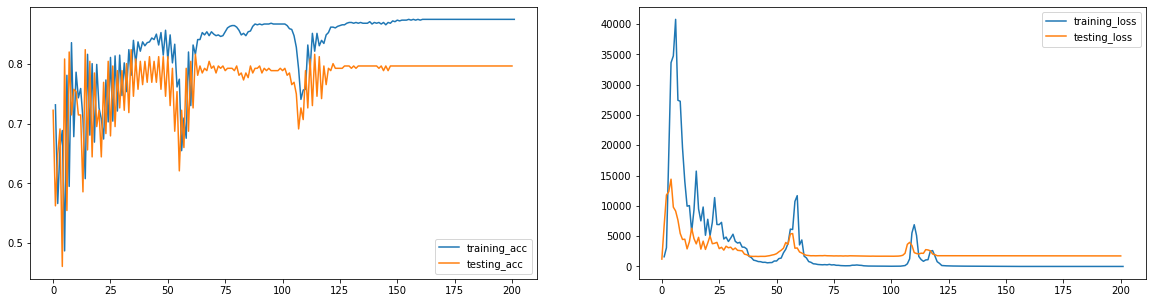

In [148]:
print("=== 1-2 Logistic regression model using batch GD ===")
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCH+1), train_acc_list, test_acc_list)
plt.legend(['training_acc', 'testing_acc'])
plt.subplot(1,2,2)
plt.plot(range(1, EPOCH+1), train_error_list, test_error_list)
plt.legend(['training_loss', 'testing_loss'])
plt.show()

In [149]:
# Logistic regression model using SGD => Batch size = 1
# Beta(t+1) = Beta(t) * lr * sigma(p-y)*x
train_error = 1000000
EPOCH = 0
weight = np.zeros([FEATURE_SIZE+1, 8])

lr = 0.002
train_error_list = []
test_error_list = []
train_acc_list = []
test_acc_list = []

while not (train_error < 5 or EPOCH > 200):
    
    # BATCHSIZE = 1
    for i in range(train.shape[0]):
        a = np.dot(weight.T, train[i].reshape(FEATURE_SIZE+1,1))
        # Perform Softmax
        y = np.exp(a) / np.sum(np.exp(a), axis=0)
        # Update Weight
        weight = (weight.T + lr * np.dot((train_t[i].reshape(8,1) - y.reshape(8,1)), train[i].reshape(1,785))).T
    
    a = np.dot(weight.T, train.T)
    # Perform Softmax
    y = np.exp(a) / np.sum(np.exp(a), axis=0)
    train_error = -np.sum(train_t.T * np.log(y))
    train_error_list.append(train_error)
    
    b = np.dot(weight.T, test.T)
    # Perform Softmax
    test_y = np.exp(b) / np.sum(np.exp(b), axis=0)
    test_error = -np.sum(test_t.T * np.log(test_y))
    test_error_list.append(test_error)

    #Accuracy
    _, train_acc = Prediction(train, train_t.T, weight)
    _, test_acc = Prediction(test, test_t.T, weight)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    EPOCH += 1

weight_list.append(weight)
train_error_final.append(train_error)
test_error_final.append(test_error)

=== 1-2 Logistic regression model using batch SD ===


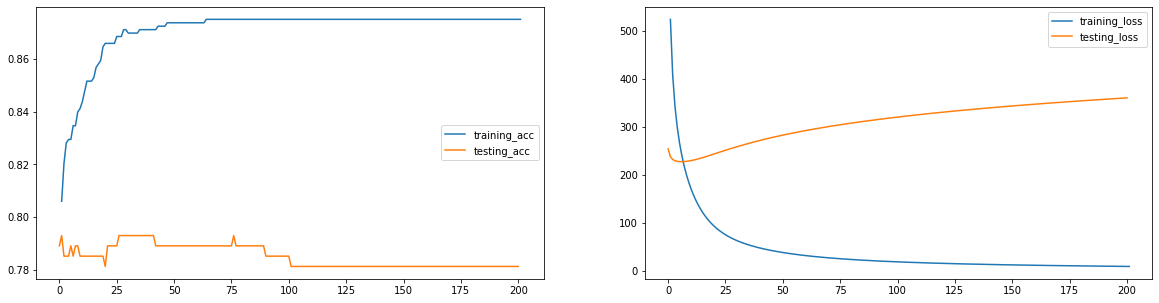

In [150]:
print("=== 1-2 Logistic regression model using batch SD ===")
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCH+1), train_acc_list, test_acc_list)
plt.legend(['training_acc', 'testing_acc'])
plt.subplot(1,2,2)
plt.plot(range(1, EPOCH+1), train_error_list, test_error_list)
plt.legend(['training_loss', 'testing_loss'])
plt.show()

In [151]:
# Logistic regression model using mini-batch SGD => Batch size = 32
# Beta(t+1) = Beta(t) * lr * sigma(p-y)*x
train_error = 1000000
EPOCH = 0
weight = np.zeros([FEATURE_SIZE+1, 8])

lr = 0.0005
train_error_list = []
test_error_list = []
train_acc_list = []
test_acc_list = []

while not (train_error < 5 or EPOCH > 200):
  
    BATCHSIZE = 64
    for i in range(train.shape[0]//BATCHSIZE):
        a = np.dot(weight.T, train[i*BATCHSIZE: (i+1)*BATCHSIZE].T)
        # Perform Softmax
        y = np.exp(a) / np.sum(np.exp(a), axis=0)
        # Update Weight
        weight = (weight.T + lr * np.dot((train_t[i*BATCHSIZE: (i+1)*BATCHSIZE].T - y.reshape(8,BATCHSIZE)), train[i*BATCHSIZE: (i+1)*BATCHSIZE].reshape(BATCHSIZE,785))).T
    
    a = np.dot(weight.T, train.T)
    # Perform Softmax
    y = np.exp(a) / np.sum(np.exp(a), axis=0)
    train_error = -np.sum(train_t.T * np.log(y))
    train_error_list.append(train_error)
    
    b = np.dot(weight.T, test.T)
    # Perform Softmax
    test_y = np.exp(b) / np.sum(np.exp(b), axis=0)
    test_error = -np.sum(test_t.T * np.log(test_y))
    test_error_list.append(test_error)

    #Accuracy
    _, train_acc = Prediction(train, train_t.T, weight)
    _, test_acc = Prediction(test, test_t.T, weight)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    EPOCH += 1

weight_list.append(weight)
train_error_final.append(train_error)
test_error_final.append(test_error)

=== 1-2 Logistic regression model using mini-batch SDG ===


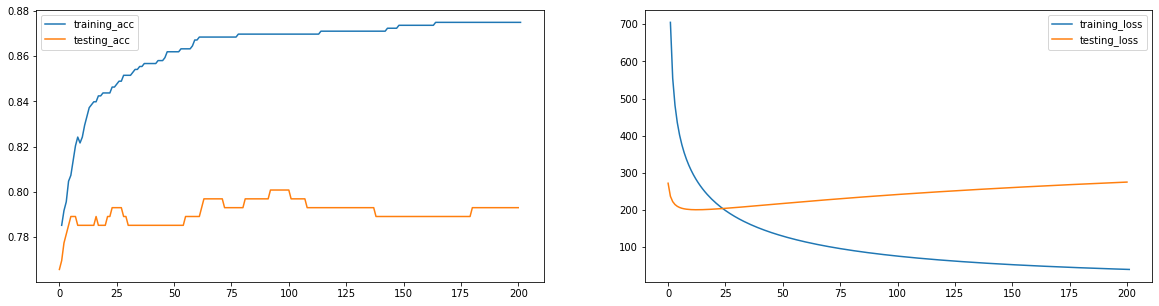

In [152]:
print("=== 1-2 Logistic regression model using mini-batch SDG ===")
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(range(1, EPOCH+1), train_acc_list, test_acc_list)
plt.legend(['training_acc', 'testing_acc'])
plt.subplot(1,2,2)
plt.plot(range(1, EPOCH+1), train_error_list, test_error_list)
plt.legend(['training_loss', 'testing_loss'])
plt.show()

In [153]:
print("=== 1-2 Final Classification Accuracy and Loss ===\n")

title_list = ['batch GD', 'SGD', 'mini-batch SGD']
for count, w in enumerate(weight_list):
    _, train_acc = Prediction(train, train_t.T, w)
    _, test_acc = Prediction(test, test_t.T, w)
   
    print('=== {} ==='.format(title_list[count]))
    print("[1]Training Dataset")
    print(" - MSE loss : ", train_error_final[count])
    print(" - Accuracy : ", train_acc*100,"%")
    print("[2]Test Dataset")
    print(" - MSE loss : ", test_error_final[count])
    print(" - Accuracy : ", test_acc*100,"%\n")

=== 1-2 Final Classification Accuracy and Loss ===

=== batch GD ===
[1]Training Dataset
 - MSE loss :  0.7958190726543408
 - Accuracy :  87.5 %
[2]Test Dataset
 - MSE loss :  1738.3117891927855
 - Accuracy :  79.6875 %

=== SGD ===
[1]Training Dataset
 - MSE loss :  9.589464714035275
 - Accuracy :  87.5 %
[2]Test Dataset
 - MSE loss :  360.8680348473155
 - Accuracy :  78.125 %

=== mini-batch SGD ===
[1]Training Dataset
 - MSE loss :  40.4916233396986
 - Accuracy :  87.5 %
[2]Test Dataset
 - MSE loss :  275.3959631607464
 - Accuracy :  79.296875 %



In [154]:
print("=== 1-2 batch GD / SGD / mini-batch SGD ===")
print("在訓練200 epoch後，三個方法在training的的accuracy則是收斂在相似處。")
print("Training過程中，batch GD理論上要是最平滑，SDG更新時理論上要是最隨機混論的")
print("但圖顯然不是這樣表達的，我認為是Data的分佈不夠隨機造成的")

=== 1-2 batch GD / SGD / mini-batch SGD ===
在訓練200 epoch後，三個方法在training的的accuracy則是收斂在相似處。
Training過程中，batch GD理論上要是最平滑，SDG更新時理論上要是最隨機混論的
但圖顯然不是這樣表達的，我認為是Data的分佈不夠隨機造成的


In [155]:
print("=== 1-3 Should we use the least squares model for classification problem ? ===")
print("My answer would be yes, but LS's result may not do well, least-squares solutions lack robustness to outliers.")
print("We can also observed from our experient that the testing result is really bad though training isn't !!")

print("Besides, logistic way works better on testing dataset as we can found on above results.")
print("Testing results in three different batchsize all show accuracy to some extent!!")


=== 1-3 Should we use the least squares model for classification problem ? ===
My answer would be yes, but LS's result may not do well, least-squares solutions lack robustness to outliers.
We can also observed from our experient that the testing result is really bad though training isn't !!
Besides, logistic way works better on testing dataset as we can found on above results.
Testing results in three different batchsize all show accuracy to some extent!!


# 2. Gaussian Process for Regression

In [156]:
def shuffle_in_unison_2(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

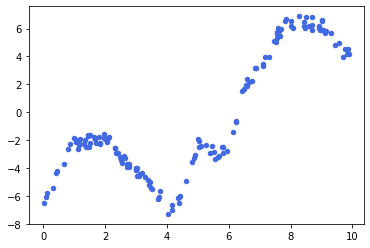

In [157]:
# Create Input Dataset

# Loading Data_Frame
data_x_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/gaussian_process_data/x.csv')
data_t_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/gaussian_process_data/t.csv')

data_x = np.array(data_x_df)
data_t = np.array(data_t_df)

data_x_df, data_t_df = shuffle_in_unison_2(data_x, data_t)

SIZE = 150
train_x = data_x[:SIZE]
train_t = data_t[:SIZE]

test_x = data_x[SIZE:]
test_t = data_t[SIZE:]

# Hyperparameters
theta_list = [[0, 0, 0, 1],
              [1, 8, 0, 0],
              [1, 1, 0, 16],
              [1, 1, 32, 0]]
beta_inv = 1

# Plot data
plt.scatter(train_x, train_t, label="data", color="royalblue",
            marker="o", s=20)
plt.show()

In [158]:
def PolyKernel(x, y):
    phi_x = np.array([1, x, x**2])
    phi_y = np.array([1, y, y**2])
    return np.dot(phi_x.T, phi_y)


def PolyGaussianProcess(xn, con_inv):
    k = np.zeros(SIZE)
    for i in range(SIZE):
      k[i] = PolyKernel(xn, train_x[i])
    var = PolyKernel(xn, xn) + beta_inv - np.dot(k, np.dot(cov_inv, k.reshape(SIZE, 1)))
    mean = np.dot(k, np.dot(con_inv, train_t.reshape(SIZE, 1)))

    return mean, var

In [159]:
def PolyCalculateError(con_inv, data_x, data_t):
    rms_error = 0
    size = data_x.shape[0]
    for i in range(size):
        mean, var = PolyGaussianProcess(data_x[i], cov_inv)
        rms_error += (mean - data_t[i]) ** 2
    rms_error = np.sqrt(rms_error/size)
    
    return rms_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


=== 2-1 ===
Training data RMS Error : [2.04592921]
Testing data RMS Error : [2.09657972]




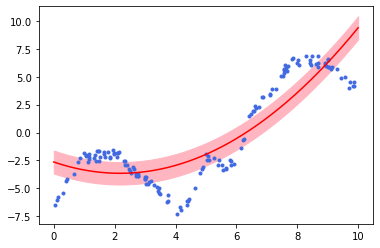

In [160]:
cov = np.zeros([SIZE, SIZE])
x = np.arange(0, 10.01, 0.01)
y = np.empty(0)
std = np.empty(0)
for i in range(SIZE):
    for j in range(SIZE):
        cov[i][j] = PolyKernel(train_x[i], train_x[j])
        if (i == j):
            cov[i][j] += beta_inv
cov_inv = np.linalg.inv(cov)
for xn in x:
    mean, var = PolyGaussianProcess(xn, cov_inv)
    y = np.append(y, mean)
    std = np.append(std, np.sqrt(var))

#Show Result
print("=== 2-1 ===")

#Calculate Error
train_rms_error = PolyCalculateError(cov_inv, train_x, train_t)
print ('Training data RMS Error : {}'.format(train_rms_error))
test_rms_error = PolyCalculateError(cov_inv, test_x, test_t)
print ('Testing data RMS Error : {}'.format(test_rms_error))
print('\n')

plt.plot(x, y, color = 'red')    
plt.fill_between(x, y - std, y + std, color = 'lightpink')
plt.scatter(train_x, train_t, color = 'royalblue', marker = '.')
plt.show()

In [161]:
def CalculateError(theta, con_inv, data_x, data_t):
    rms_error = 0
    size = data_x.shape[0]
    for i in range(size):
        mean, var = GaussianProcess(theta, data_x[i], cov_inv)
        rms_error += (mean - data_t[i]) ** 2
    rms_error = np.sqrt(rms_error/size)
    
    return rms_error

In [162]:
def ExponentialQuadraticKernel(theta, xn, xm):
    return theta[0] * (np.exp(-theta[1]/2 * (xn-xm)**2)) + theta[2] + theta[3] * xn * xm

def GaussianProcess(theta, xn, con_inv):
    k = np.zeros(SIZE)
    for i in range(SIZE):
      k[i] = ExponentialQuadraticKernel(theta, xn, train_x[i])
    var = ExponentialQuadraticKernel(theta, xn, xn) + beta_inv - np.dot(k, np.dot(cov_inv, k.reshape(SIZE, 1)))
    mean = np.dot(k, np.dot(con_inv, train_t.reshape(SIZE, 1)))

    return mean, var

=== 2-2, 2-3, 2-4 : case 1 === 


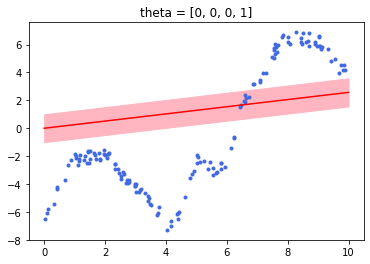

Training data RMS Error : [4.09045082]
Testing data RMS Error : [3.93528021]


=== 2-2, 2-3, 2-4 : case 2 === 


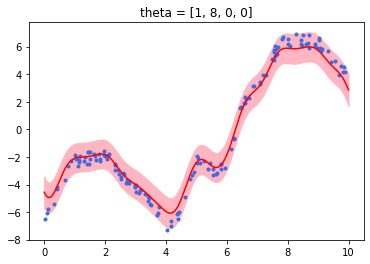

Training data RMS Error : [0.46873214]
Testing data RMS Error : [0.49366074]


=== 2-2, 2-3, 2-4 : case 3 === 


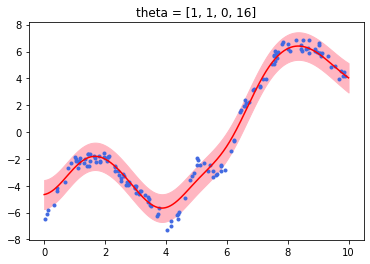

Training data RMS Error : [0.60287327]
Testing data RMS Error : [0.58307623]


=== 2-2, 2-3, 2-4 : case 4 === 


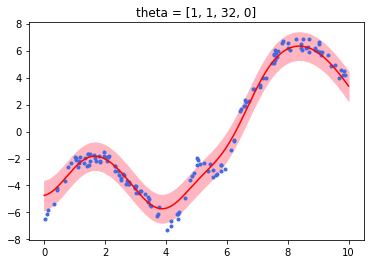

Training data RMS Error : [0.60151368]
Testing data RMS Error : [0.58780669]




In [163]:
for count, theta in enumerate(theta_list):
  cov = np.zeros([SIZE, SIZE])
  x = np.arange(0, 10.01, 0.01)
  y = np.empty(0)
  std = np.empty(0)
  for i in range(SIZE):
      for j in range(SIZE):
          cov[i][j] = ExponentialQuadraticKernel(theta, train_x[i], train_x[j])
          if (i == j):
              cov[i][j] += beta_inv
  cov_inv = np.linalg.inv(cov)
  for xn in x:
      mean, var = GaussianProcess(theta, xn, cov_inv)
      y = np.append(y, mean)
      std = np.append(std, np.sqrt(var))
  
  #Show Result
  print("=== 2-2, 2-3, 2-4 : case {} === ".format(count+1))
  
  #Plot
  plt.plot(x, y, color = 'red')    
  plt.fill_between(x, y - std, y + std, color = 'lightpink')
  plt.scatter(train_x, train_t, color = 'royalblue', marker = '.')
  plt.title("theta = {}".format(theta))
  plt.show()
  
  #Calculate Error
  train_rms_error = CalculateError(theta, cov_inv, train_x, train_t)
  print ('Training data RMS Error : {}'.format(train_rms_error))
  test_rms_error = CalculateError(theta, cov_inv, test_x, test_t)
  print ('Testing data RMS Error : {}'.format(test_rms_error))
  print('\n')

In [164]:
print("=== 2-5 Trial & Error To Find Hyperparameter === ")
print("Show Below")


=== 2-5 Trial & Error To Find Hyperparameter === 
Show Below


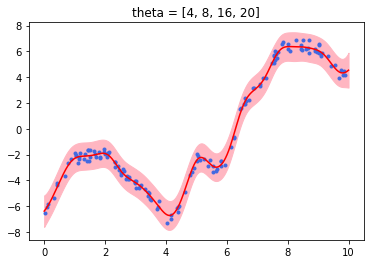

Training data RMS Error : [0.26219509]
Testing data RMS Error : [0.32787754]




In [165]:
theta = [4, 8, 16, 20]
cov = np.zeros([SIZE, SIZE])
x = np.arange(0, 10.01, 0.01)
y = np.empty(0)
std = np.empty(0)
for i in range(SIZE):
    for j in range(SIZE):
        cov[i][j] = ExponentialQuadraticKernel(theta, train_x[i], train_x[j])
        if (i == j):
            cov[i][j] += beta_inv
cov_inv = np.linalg.inv(cov)
for xn in x:
    mean, var = GaussianProcess(theta, xn, cov_inv)
    y = np.append(y, mean)
    std = np.append(std, np.sqrt(var))

#Plot
plt.plot(x, y, color = 'red')    
plt.fill_between(x, y - std, y + std, color = 'lightpink')
plt.scatter(train_x, train_t, color = 'royalblue', marker = '.')
plt.title("theta = {}".format(theta))
plt.show()

#Calculate Error
train_rms_error = CalculateError(theta, cov_inv, train_x, train_t)
print ('Training data RMS Error : {}'.format(train_rms_error))
test_rms_error = CalculateError(theta, cov_inv, test_x, test_t)
print ('Testing data RMS Error : {}'.format(test_rms_error))
print('\n')

In [166]:
print("=== 2-6 Discussion === ")
print("[1] Discussion ")
print("- theta 0 : overall variance")
print("- theta 1 : 1/lengthscale^2")
print("- theta 2 : constant")
print("- theaa 3 : linear constant")
print("Trial & Error的時候，基於上述的參數去調整，可以利用高斯smooth點的分佈，但刻意調到到fit training data")
print("會讓他線條不夠smooth。\n")

print("[2] Discussion ")
print("將Expo跟Poly kernel比較可以看到，M=2的多項式Kernel，沒辦法General的表達Data的分佈，可見Model的複雜度不夠高")

=== 2-6 Discussion === 
[1] Discussion 
- theta 0 : overall variance
- theta 1 : 1/lengthscale^2
- theta 2 : constant
- theaa 3 : linear constant
Trial & Error的時候，基於上述的參數去調整，可以利用高斯smooth點的分佈，但刻意調到到fit training data
會讓他線條不夠smooth。

[2] Discussion 
將Expo跟Poly kernel比較可以看到，M=2的多項式Kernel，沒辦法General的表達Data的分佈，可見Model的複雜度不夠高
